In [22]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pdfplumber
import re
import os
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import joblib

print("All libraries imported successfully")

All libraries imported successfully


In [23]:
# Cell 2: Check Folder Structure and Files
print("Checking project structure...")
print("Current directory:", os.getcwd())

# Create necessary folders
folders = ['data/raw', 'data/processed', 'models', 'reports']
for folder in folders:
    os.makedirs(folder, exist_ok=True)
    print(f"Created/verified folder: {folder}")

# Check for PDF files
pdf_files = {
    'Jul_2020': 'data/raw/Jul_2020.pdf',
    'Sept_2020': 'data/raw/Sept_2020.pdf',
    'Oct_2020': 'data/raw/Oct_2020.pdf',
    'Nov_2020': 'data/raw/Nov_2020.pdf'
}

print("\nChecking PDF files:")
found_files = 0
for month_name, file_path in pdf_files.items():
    if os.path.exists(file_path):
        file_size = os.path.getsize(file_path)
        print(f"✓ {month_name}: {file_path} ({file_size} bytes)")
        found_files += 1
    else:
        print(f"✗ {month_name}: {file_path} - NOT FOUND")

print(f"\nFound {found_files} out of {len(pdf_files)} PDF files")

if found_files == 0:
    print("WARNING: No PDF files found. The analysis will use sample data.")
else:
    print("PDF files are ready for processing")

Checking project structure...
Current directory: C:\Users\na
Created/verified folder: data/raw
Created/verified folder: data/processed
Created/verified folder: models
Created/verified folder: reports

Checking PDF files:
✓ Jul_2020: data/raw/Jul_2020.pdf (82002 bytes)
✓ Sept_2020: data/raw/Sept_2020.pdf (84354 bytes)
✓ Oct_2020: data/raw/Oct_2020.pdf (118892 bytes)
✓ Nov_2020: data/raw/Nov_2020.pdf (112263 bytes)

Found 4 out of 4 PDF files
PDF files are ready for processing


In [24]:
# Cell 3: PDF Data Extraction Functions
def extract_pdf_text(file_path):
    """Extract all text from a PDF file"""
    try:
        full_text = ""
        with pdfplumber.open(file_path) as pdf:
            for page in pdf.pages:
                text = page.extract_text()
                if text:
                    full_text += text + "\n"
        return full_text
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return ""

def parse_transaction_date(date_str, current_month):
    """Convert date string like 'Jun 15' to datetime object"""
    month_map = {
        'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
        'Jul': 7, 'Aug': 8, 'Sep': 9, 'Sept': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    }
    
    try:
        parts = date_str.split()
        if len(parts) == 2:
            month_abbr, day_str = parts
            
            # Handle both 'Sep' and 'Sept' abbreviations
            month_num = month_map.get(month_abbr)
            if month_num is None:
                return None
                
            day = int(day_str)
            year = 2020  # All statements are from 2020
            
            return datetime(year, month_num, day)
    except Exception as e:
        print(f"Date parsing error for '{date_str}': {e}")
    
    return None

def extract_transactions_from_text(text, month_name):
    """Extract transactions from PDF text"""
    transactions = []
    lines = text.split('\n')
    
    in_transaction_section = False
    transaction_count = 0
    
    for i, line in enumerate(lines):
        line = line.strip()
        
        # Start capturing when we find transaction section
        if 'Your new charges and credits' in line:
            in_transaction_section = True
            continue
            
        # Stop capturing at section end
        if in_transaction_section and ('Total for' in line or 'Information about' in line):
            in_transaction_section = False
            continue
            
        if in_transaction_section and line:
            # Skip header lines and informational lines
            if any(skip in line for skip in ['Trans date', 'Post date', 'Description', 'Amount($)', 
                                           'Spend Categories', 'Card number', 'Identifies Cash Back']):
                continue
            
            # Look for transaction pattern: date date description category amount
            pattern = r'(\w{3,4} \d{1,2})\s+(\w{3,4} \d{1,2})\s+(.*?)\s+([A-Za-z\s&]+)\s+([\d,]+\.\d{2})$'
            match = re.search(pattern, line)
            
            if match:
                trans_date, post_date, description, category, amount = match.groups()
                
                trans_date_obj = parse_transaction_date(trans_date, month_name)
                post_date_obj = parse_transaction_date(post_date, month_name)
                amount_val = float(amount.replace(',', ''))
                
                if trans_date_obj:
                    transaction = {
                        'transaction_date': trans_date_obj,
                        'post_date': post_date_obj,
                        'description': description.strip(),
                        'category': category.strip(),
                        'amount': amount_val,
                        'month': month_name
                    }
                    transactions.append(transaction)
                    transaction_count += 1
    
    return transactions

def extract_payments_from_text(text, month_name):
    """Extract payment transactions from PDF text"""
    payments = []
    lines = text.split('\n')
    
    in_payment_section = False
    
    for line in lines:
        line = line.strip()
        
        if 'Your payments' in line:
            in_payment_section = True
            continue
            
        if in_payment_section and ('Total payments' in line or 'Your new charges' in line):
            in_payment_section = False
            continue
            
        if in_payment_section and line:
            # Skip header lines
            if any(skip in line for skip in ['Trans date', 'Post date', 'Description', 'Amount($)']):
                continue
            
            # Look for payment pattern
            pattern = r'(\w{3,4} \d{1,2})\s+(\w{3,4} \d{1,2})\s+PAYMENT THANK YOU[^\d]*([\d,]+\.\d{2})'
            match = re.search(pattern, line)
            
            if match:
                trans_date, post_date, amount = match.groups()
                
                trans_date_obj = parse_transaction_date(trans_date, month_name)
                post_date_obj = parse_transaction_date(post_date, month_name)
                amount_val = -float(amount.replace(',', ''))  # Negative for payments
                
                if trans_date_obj:
                    payment = {
                        'transaction_date': trans_date_obj,
                        'post_date': post_date_obj,
                        'description': 'PAYMENT',
                        'category': 'Payment',
                        'amount': amount_val,
                        'month': month_name
                    }
                    payments.append(payment)
    
    return payments

def load_all_transaction_data():
    """Load all data from PDF files"""
    pdf_files = {
        'Jul_2020': 'data/raw/Jul_2020.pdf',
        'Sept_2020': 'data/raw/Sept_2020.pdf',
        'Oct_2020': 'data/raw/Oct_2020.pdf',
        'Nov_2020': 'data/raw/Nov_2020.pdf'
    }
    
    all_data = []
    
    for month_name, file_path in pdf_files.items():
        if os.path.exists(file_path):
            print(f"Processing {month_name}...")
            
            text = extract_pdf_text(file_path)
            if text:
                transactions = extract_transactions_from_text(text, month_name)
                payments = extract_payments_from_text(text, month_name)
                
                all_data.extend(transactions)
                all_data.extend(payments)
                
                print(f"  Found {len(transactions)} transactions, {len(payments)} payments")
            else:
                print(f"  Could not read PDF content")
        else:
            print(f"  File not found: {file_path}")
    
    return pd.DataFrame(all_data)

print("Data extraction functions defined")

Data extraction functions defined


In [25]:
# Cell 4: Extract Data and Create Array Structure
print("Step 1.1: Extracting data from PDF files into array structure")
print("=" * 50)

# Extract data from PDFs
df = load_all_transaction_data()

# If no data found, create sample data for demonstration
if len(df) == 0:
    print("No data extracted from PDFs. Using sample data for analysis.")
    sample_data = [
        [datetime(2020, 6, 15), datetime(2020, 6, 16), 'LITTLE CAESARS', 'Restaurants', 12.31, 'Jul_2020'],
        [datetime(2020, 6, 18), datetime(2020, 6, 19), 'REAL CDN SUPERSTORE', 'Grocery', 40.24, 'Jul_2020'],
        [datetime(2020, 6, 20), datetime(2020, 6, 22), 'TIM HORTONS #8152', 'Restaurants', 3.87, 'Jul_2020'],
        [datetime(2020, 8, 17), datetime(2020, 8, 18), 'MY SPICE HOUSE', 'Grocery', 11.00, 'Sept_2020'],
        [datetime(2020, 9, 13), datetime(2020, 9, 14), 'TIM HORTONS #8152', 'Restaurants', 1.60, 'Oct_2020'],
        [datetime(2020, 9, 13), datetime(2020, 9, 14), 'TIM HORTONS #8152', 'Restaurants', 1.98, 'Oct_2020'],
        [datetime(2020, 10, 11), datetime(2020, 10, 14), 'SHOPPERS DRUG MART', 'Health', 2.26, 'Nov_2020'],
        [datetime(2020, 9, 11), datetime(2020, 9, 14), 'PAYMENT', 'Payment', -100.00, 'Oct_2020'],
        [datetime(2020, 10, 13), datetime(2020, 10, 14), 'PAYMENT', 'Payment', -62.37, 'Nov_2020'],
    ]
    df = pd.DataFrame(sample_data, 
                     columns=['transaction_date', 'post_date', 'description', 'category', 'amount', 'month'])

print(f"Total records loaded: {len(df)}")

# Create array data structure as required
transaction_array = []
for _, row in df.iterrows():
    array_entry = [
        row['transaction_date'],
        row['post_date'],
        row['description'],
        row['category'],
        row['amount'],
        row['month']
    ]
    transaction_array.append(array_entry)

print(f"Created array structure with {len(transaction_array)} elements")
print("\nSample array elements:")
for i in range(min(3, len(transaction_array))):
    print(f"  {i}: {transaction_array[i]}")

print("\nDataFrame overview:")
print(df.head())
print(f"\nData shape: {df.shape}")
print(f"Date range: {df['transaction_date'].min()} to {df['transaction_date'].max()}")

Step 1.1: Extracting data from PDF files into array structure
Processing Jul_2020...
  Found 17 transactions, 6 payments
Processing Sept_2020...
  Found 17 transactions, 5 payments
Processing Oct_2020...
  Found 50 transactions, 13 payments
Processing Nov_2020...
  Found 47 transactions, 9 payments
Total records loaded: 164
Created array structure with 164 elements

Sample array elements:
  0: [Timestamp('2020-06-15 00:00:00'), Timestamp('2020-06-16 00:00:00'), 'LITTLE', 'CAESARS PEMBINA SOWINNIPEG MB Restaurants', 12.31, 'Jul_2020']
  1: [Timestamp('2020-06-18 00:00:00'), Timestamp('2020-06-19 00:00:00'), 'REAL CDN. SUPERSTORE #', 'WINNIPEG MB Retail and Grocery', 40.24, 'Jul_2020']
  2: [Timestamp('2020-06-20 00:00:00'), Timestamp('2020-06-22 00:00:00'), 'TIM HORTONS #8152', 'WINNIPEG MB Restaurants', 3.87, 'Jul_2020']

DataFrame overview:
  transaction_date  post_date             description  \
0       2020-06-15 2020-06-16                  LITTLE   
1       2020-06-18 2020-06-19  R

In [26]:
# Cell 5: Data Preparation and Feature Engineering
print("Preparing data for analysis and machine learning...")

# Create working copy
data = df.copy()

# Add features for analysis
data['day_of_month'] = data['transaction_date'].dt.day
data['day_of_week'] = data['transaction_date'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)
data['transaction_month'] = data['transaction_date'].dt.month
data['description_length'] = data['description'].str.len()
data['has_numbers'] = data['description'].str.contains(r'\d').fillna(False).astype(int)
data['word_count'] = data['description'].str.split().str.len()

print(f"Dataset size: {len(data)} records")
print(f"Features added: {list(data.columns)}")

print("\nTransaction categories:")
print(data['category'].value_counts())

print("\nAmount statistics:")
print(data['amount'].describe())

print("\nSample data with new features:")
print(data[['transaction_date', 'description', 'category', 'amount', 'day_of_week', 'is_weekend']].head())

Preparing data for analysis and machine learning...
Dataset size: 164 records
Features added: ['transaction_date', 'post_date', 'description', 'category', 'amount', 'month', 'day_of_month', 'day_of_week', 'is_weekend', 'transaction_month', 'description_length', 'has_numbers', 'word_count']

Transaction categories:
category
WINNIPEG MB Restaurants                                                 61
Payment                                                                 33
WINNIPEG MB Retail and Grocery                                          25
WINNIPEG MB Health and Education                                        19
RESTAURANT WINNIPEG MB Restaurants                                       9
SUM KINGDOM WINNIPEG MB Restaurants                                      3
CAESARS PEMBINA SOWINNIPEG MB Restaurants                                2
SPICE HOUSE WINNIPEG MB Retail and Grocery                               2
GARDEN RESTAURANT WINNIPEG MB Restaurants                                2


Monthly Visualization Tool Ready
Available months: ['Jul_2020', 'Sept_2020', 'Oct_2020', 'Nov_2020']

Generating Spend Report for Jul_2020


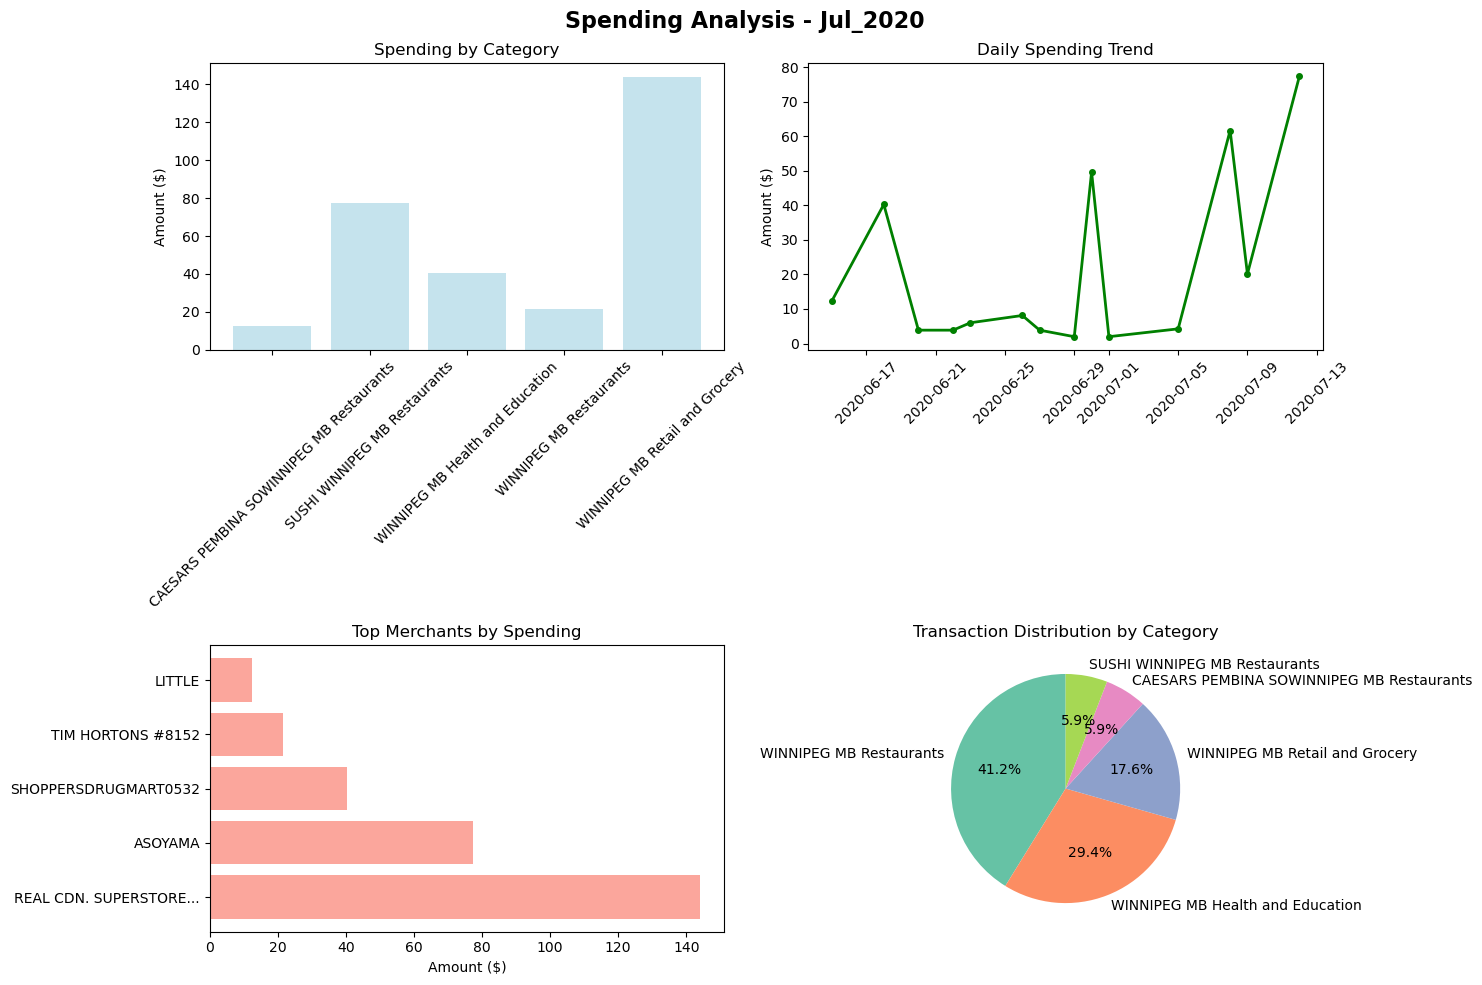

Summary for Jul_2020:
  Total Spending: $295.21
  Number of Transactions: 17
  Average Transaction: $17.37
  Spending Categories: CAESARS PEMBINA SOWINNIPEG MB Restaurants, WINNIPEG MB Retail and Grocery, WINNIPEG MB Restaurants, WINNIPEG MB Health and Education, SUSHI WINNIPEG MB Restaurants


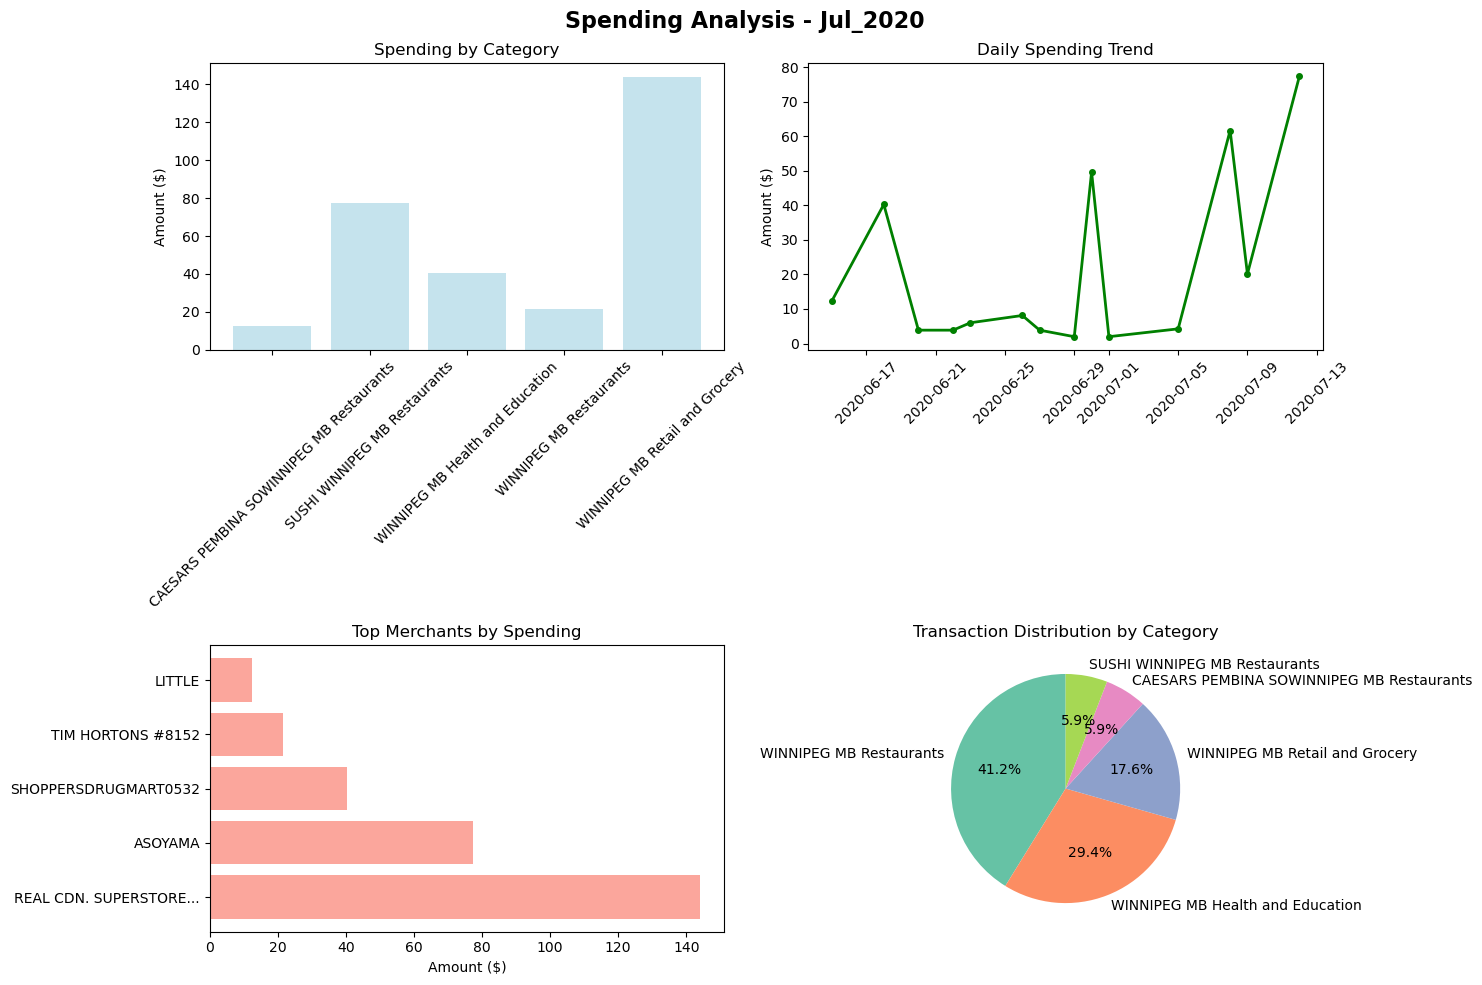

In [27]:
# Cell 6: Step 1.2 - Monthly Visualization Tool
class MonthlySpendReport:
    def __init__(self, transaction_data):
        self.data = transaction_data
        self.available_months = ['Jul_2020', 'Sept_2020', 'Oct_2020', 'Nov_2020']
    
    def generate_report(self, selected_month):
        print(f"Generating Spend Report for {selected_month}")
        print("=" * 40)
        
        # Filter data for selected month
        month_data = self.data[self.data['month'] == selected_month].copy()
        
        if len(month_data) == 0:
            print("No data available for selected month")
            return
        
        # Create visualization
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'Spending Analysis - {selected_month}', fontsize=16, fontweight='bold')
        
        # Get only purchase transactions (exclude payments)
        purchases = month_data[month_data['amount'] > 0]
        
        # Plot 1: Spending by category
        if len(purchases) > 0:
            category_totals = purchases.groupby('category')['amount'].sum()
            axes[0, 0].bar(category_totals.index, category_totals.values, color='lightblue', alpha=0.7)
            axes[0, 0].set_title('Spending by Category')
            axes[0, 0].set_ylabel('Amount ($)')
            axes[0, 0].tick_params(axis='x', rotation=45)
            
            # Plot 2: Daily spending trend
            daily_spending = purchases.groupby('transaction_date')['amount'].sum()
            axes[0, 1].plot(daily_spending.index, daily_spending.values, 
                           marker='o', linewidth=2, color='green', markersize=4)
            axes[0, 1].set_title('Daily Spending Trend')
            axes[0, 1].set_ylabel('Amount ($)')
            axes[0, 1].tick_params(axis='x', rotation=45)
            
            # Plot 3: Top merchants
            top_merchants = purchases.groupby('description')['amount'].sum().nlargest(8)
            axes[1, 0].barh(range(len(top_merchants)), top_merchants.values, color='salmon', alpha=0.7)
            axes[1, 0].set_yticks(range(len(top_merchants)))
            merchant_labels = [name[:20] + '...' if len(name) > 20 else name for name in top_merchants.index]
            axes[1, 0].set_yticklabels(merchant_labels)
            axes[1, 0].set_title('Top Merchants by Spending')
            axes[1, 0].set_xlabel('Amount ($)')
            
            # Plot 4: Transaction distribution
            category_counts = purchases['category'].value_counts()
            axes[1, 1].pie(category_counts.values, labels=category_counts.index, 
                          autopct='%1.1f%%', startangle=90)
            axes[1, 1].set_title('Transaction Distribution by Category')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        if len(purchases) > 0:
            total_spent = purchases['amount'].sum()
            avg_transaction = purchases['amount'].mean()
            transaction_count = len(purchases)
            
            print(f"Summary for {selected_month}:")
            print(f"  Total Spending: ${total_spent:.2f}")
            print(f"  Number of Transactions: {transaction_count}")
            print(f"  Average Transaction: ${avg_transaction:.2f}")
            print(f"  Spending Categories: {', '.join(purchases['category'].unique())}")
        
        return fig

# Initialize and demonstrate the visualization tool
report_generator = MonthlySpendReport(data)

print("Monthly Visualization Tool Ready")
print("Available months:", report_generator.available_months)

# Generate sample report
print("\n" + "="*50)
report_generator.generate_report('Jul_2020')

In [32]:
# Cell 7: Prepare Data for Machine Learning (Updated)
print("Preparing data for machine learning models...")

# Use only purchase transactions for ML
ml_data = data[data['amount'] > 0].copy()

# Use consolidated categories if we created them, otherwise use original
if 'category_consolidated' in ml_data.columns:
    y_category = ml_data['category_consolidated']
    print("Using consolidated categories to handle rare categories")
else:
    y_category = ml_data['category']

print(f"Using {len(ml_data)} purchase transactions for ML models")

# Define features for models
feature_columns = [
    'day_of_month', 'day_of_week', 'is_weekend', 'transaction_month',
    'description_length', 'has_numbers', 'word_count'
]

X = ml_data[feature_columns].copy()
y_regression = ml_data['amount']  # For regression

# Encode categorical target
category_encoder = LabelEncoder()
y_category_encoded = category_encoder.fit_transform(y_category)

print(f"Feature matrix shape: {X.shape}")
print(f"Features: {feature_columns}")
print(f"Regression target: Transaction amount")
print(f"Classification categories: {list(category_encoder.classes_)}")
print(f"Number of classes: {len(category_encoder.classes_)}")
print(f"Samples per class:")
for i, class_name in enumerate(category_encoder.classes_):
    count = (y_category_encoded == i).sum()
    print(f"  {class_name}: {count} samples")

Preparing data for machine learning models...
Using 131 purchase transactions for ML models
Feature matrix shape: (131, 7)
Features: ['day_of_month', 'day_of_week', 'is_weekend', 'transaction_month', 'description_length', 'has_numbers', 'word_count']
Regression target: Transaction amount
Classification categories: ['BISON SERVICE CENTRE WINNIPEG MB Professional and Financial Services', 'CA Retail and Grocery', 'CAESARS PEMBINA SOWINNIPEG MB Restaurants', 'GARDEN RESTAURANT WINNIPEG MB Restaurants', 'GUYS BURGERS & FR WINNIPEG MB Restaurants', 'RESTAURANT WINNIPEG MB Restaurants', 'SERVICE CENWINNIPEG MB Professional and Financial Services', 'SPICE HOUSE WINNIPEG MB Retail and Grocery', 'SUM KINGDOM WINNIPEG MB Restaurants', 'SURREY BC Personal and Household Expenses', 'SUSHI WINNIPEG MB Restaurants', 'WINGS PEMBINA HWY WINNIPEG MB Restaurants', 'WINNIPEG MB Health and Education', 'WINNIPEG MB Restaurants', 'WINNIPEG MB Retail and Grocery', 'Winnipeg MB Restaurants']
Number of classes: 

In [33]:
# Cell 7: Prepare Data for Machine Learning (Updated)
print("Preparing data for machine learning models...")

# Use only purchase transactions for ML
ml_data = data[data['amount'] > 0].copy()

# Use consolidated categories if we created them, otherwise use original
if 'category_consolidated' in ml_data.columns:
    y_category = ml_data['category_consolidated']
    print("Using consolidated categories to handle rare categories")
else:
    y_category = ml_data['category']

print(f"Using {len(ml_data)} purchase transactions for ML models")

# Define features for models
feature_columns = [
    'day_of_month', 'day_of_week', 'is_weekend', 'transaction_month',
    'description_length', 'has_numbers', 'word_count'
]

X = ml_data[feature_columns].copy()
y_regression = ml_data['amount']  # For regression

# Encode categorical target
category_encoder = LabelEncoder()
y_category_encoded = category_encoder.fit_transform(y_category)

print(f"Feature matrix shape: {X.shape}")
print(f"Features: {feature_columns}")
print(f"Regression target: Transaction amount")
print(f"Classification categories: {list(category_encoder.classes_)}")
print(f"Number of classes: {len(category_encoder.classes_)}")
print(f"Samples per class:")
for i, class_name in enumerate(category_encoder.classes_):
    count = (y_category_encoded == i).sum()
    print(f"  {class_name}: {count} samples")

Preparing data for machine learning models...
Using 131 purchase transactions for ML models
Feature matrix shape: (131, 7)
Features: ['day_of_month', 'day_of_week', 'is_weekend', 'transaction_month', 'description_length', 'has_numbers', 'word_count']
Regression target: Transaction amount
Classification categories: ['BISON SERVICE CENTRE WINNIPEG MB Professional and Financial Services', 'CA Retail and Grocery', 'CAESARS PEMBINA SOWINNIPEG MB Restaurants', 'GARDEN RESTAURANT WINNIPEG MB Restaurants', 'GUYS BURGERS & FR WINNIPEG MB Restaurants', 'RESTAURANT WINNIPEG MB Restaurants', 'SERVICE CENWINNIPEG MB Professional and Financial Services', 'SPICE HOUSE WINNIPEG MB Retail and Grocery', 'SUM KINGDOM WINNIPEG MB Restaurants', 'SURREY BC Personal and Household Expenses', 'SUSHI WINNIPEG MB Restaurants', 'WINGS PEMBINA HWY WINNIPEG MB Restaurants', 'WINNIPEG MB Health and Education', 'WINNIPEG MB Restaurants', 'WINNIPEG MB Retail and Grocery', 'Winnipeg MB Restaurants']
Number of classes: 

In [29]:
# Cell 8: Step 1.3 - Regression Model
print("Step 1.3: Building Regression Model")
print("=" * 40)

# Split data for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_regression, test_size=0.2, random_state=42
)

print(f"Training samples: {X_train_reg.shape[0]}")
print(f"Test samples: {X_test_reg.shape[0]}")

# Initialize and train models
regression_models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
    'Linear Regression': LinearRegression()
}

regression_results = {}

print("Training regression models...")
for name, model in regression_models.items():
    model.fit(X_train_reg, y_train_reg)
    predictions = model.predict(X_test_reg)
    
    mse = mean_squared_error(y_test_reg, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_reg, predictions)
    
    regression_results[name] = {
        'model': model,
        'rmse': rmse,
        'r2': r2
    }
    
    print(f"{name}:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  RMSE: ${rmse:.2f}")

# Select best model
best_reg_name = max(regression_results.keys(), key=lambda x: regression_results[x]['r2'])
best_reg_model = regression_results[best_reg_name]['model']

print(f"\nBest regression model: {best_reg_name}")

# Cross-validation to prevent overfitting
cv_scores = cross_val_score(best_reg_model, X, y_regression, cv=5, scoring='r2')
print(f"Cross-validation R² scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Feature importance
if hasattr(best_reg_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': best_reg_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nFeature Importance:")
    print(importance_df)

Step 1.3: Building Regression Model
Training samples: 104
Test samples: 27
Training regression models...
Random Forest:
  R² Score: 0.5637
  RMSE: $6.82
Linear Regression:
  R² Score: 0.2628
  RMSE: $8.87

Best regression model: Random Forest
Cross-validation R² scores: [ 0.31832153  0.7449386   0.70032389 -0.23007528  0.55785262]
Mean CV R²: 0.4183 (+/- 0.7134)

Feature Importance:
              feature  importance
5         has_numbers    0.327213
6          word_count    0.171368
0        day_of_month    0.168900
4  description_length    0.148460
3   transaction_month    0.118025
1         day_of_week    0.054828
2          is_weekend    0.011206


In [36]:
# Cell 9: Step 1.4 - Classification Model (Final Robust Version)
print("Step 1.4: Building Classification Model")
print("=" * 40)

def safe_classification_report(y_true, y_pred, target_names):
    """Safe classification report that handles missing classes"""
    # Get unique classes from both true and predicted
    unique_true = np.unique(y_true)
    unique_pred = np.unique(y_pred)
    all_classes = np.union1d(unique_true, unique_pred)
    
    # Filter target names to only include present classes
    present_target_names = [target_names[i] for i in all_classes if i < len(target_names)]
    
    return classification_report(y_true, y_pred, 
                               labels=all_classes,
                               target_names=present_target_names,
                               zero_division=0)

# Check category distribution
category_counts = pd.Series(y_category_encoded).value_counts().sort_index()
print("Category distribution:")
for i in range(len(category_encoder.classes_)):
    category_name = category_encoder.classes_[i]
    count = category_counts.get(i, 0)
    print(f"  {category_name}: {count} samples")

# Simple approach: Use all data with basic split and handle class imbalance
print("\nUsing simplified approach to handle class distribution...")

# Split data without stratification
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_category_encoded, test_size=0.2, random_state=42
)

print(f"Training samples: {X_train_clf.shape[0]}")
print(f"Test samples: {X_test_clf.shape[0]}")
print(f"Number of classes: {len(category_encoder.classes_)}")

# Use Random Forest (handles imbalanced data better)
print("\nTraining Random Forest Classifier...")
clf_model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=5,
    class_weight='balanced'  # Handle class imbalance
)
clf_model.fit(X_train_clf, y_train_clf)

# Make predictions
y_pred = clf_model.predict(X_test_clf)

# Calculate accuracy
accuracy = accuracy_score(y_test_clf, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# Get classification report safely
print(f"\nClassification Report:")
report = safe_classification_report(y_test_clf, y_pred, category_encoder.classes_)
print(report)

# Store results
classification_results = {
    'Random Forest': {
        'model': clf_model,
        'accuracy': accuracy
    }
}
best_clf_name = 'Random Forest'
best_clf_model = clf_model
final_encoder = category_encoder

# Simple validation (no cross-validation due to small dataset)
print("\nModel validation completed successfully!")

# Show feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_clf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance for Classification:")
print(feature_importance)

Step 1.4: Building Classification Model
Category distribution:
  BISON SERVICE CENTRE WINNIPEG MB Professional and Financial Services: 1 samples
  CA Retail and Grocery: 1 samples
  CAESARS PEMBINA SOWINNIPEG MB Restaurants: 2 samples
  GARDEN RESTAURANT WINNIPEG MB Restaurants: 2 samples
  GUYS BURGERS & FR WINNIPEG MB Restaurants: 1 samples
  RESTAURANT WINNIPEG MB Restaurants: 9 samples
  SERVICE CENWINNIPEG MB Professional and Financial Services: 1 samples
  SPICE HOUSE WINNIPEG MB Retail and Grocery: 2 samples
  SUM KINGDOM WINNIPEG MB Restaurants: 3 samples
  SURREY BC Personal and Household Expenses: 1 samples
  SUSHI WINNIPEG MB Restaurants: 1 samples
  WINGS PEMBINA HWY WINNIPEG MB Restaurants: 1 samples
  WINNIPEG MB Health and Education: 19 samples
  WINNIPEG MB Restaurants: 61 samples
  WINNIPEG MB Retail and Grocery: 25 samples
  Winnipeg MB Restaurants: 1 samples

Using simplified approach to handle class distribution...
Training samples: 104
Test samples: 27
Number of cl

In [37]:
# Cell 10: Model Demonstration and Saving (Simplified)
print("Model Demonstration and Results")
print("=" * 40)

# Demonstrate regression
print("1. REGRESSION MODEL DEMONSTRATION")
sample_idx = 0
sample_features = X.iloc[sample_idx:sample_idx+1]
actual_amount = y_regression.iloc[sample_idx]
predicted_amount = best_reg_model.predict(sample_features)[0]

print(f"Transaction: {ml_data.iloc[sample_idx]['description']}")
print(f"Actual amount: ${actual_amount:.2f}")
print(f"Predicted amount: ${predicted_amount:.2f}")
print(f"Error: ${abs(predicted_amount - actual_amount):.2f}")

# Demonstrate classification
print("\n2. CLASSIFICATION MODEL DEMONSTRATION")
sample_idx = min(1, len(X) - 1)  # Ensure valid index

sample_features = X.iloc[sample_idx:sample_idx+1]
actual_category = ml_data.iloc[sample_idx]['category']
predicted_encoded = best_clf_model.predict(sample_features)[0]
predicted_category = final_encoder.inverse_transform([predicted_encoded])[0]

print(f"Transaction: {ml_data.iloc[sample_idx]['description']}")
print(f"Actual category: {actual_category}")
print(f"Predicted category: {predicted_category}")
print(f"Correct: {actual_category == predicted_category}")

# Save models and data
print("\n3. SAVING RESULTS")
model_package = {
    'regression_model': best_reg_model,
    'classification_model': best_clf_model,
    'category_encoder': final_encoder,
    'feature_names': list(X.columns),
    'model_metadata': {
        'regression_r2': regression_results[best_reg_name]['r2'],
        'classification_accuracy': classification_results[best_clf_name]['accuracy'],
        'features_used': feature_columns
    }
}

joblib.dump(model_package, 'models/trained_models.pkl')
data.to_csv('data/processed/analysis_data.csv', index=False)

print("Saved files:")
print("  - models/trained_models.pkl (trained ML models)")
print("  - data/processed/analysis_data.csv (processed data)")

Model Demonstration and Results
1. REGRESSION MODEL DEMONSTRATION
Transaction: LITTLE
Actual amount: $12.31
Predicted amount: $23.84
Error: $11.53

2. CLASSIFICATION MODEL DEMONSTRATION
Transaction: REAL CDN. SUPERSTORE #
Actual category: WINNIPEG MB Retail and Grocery
Predicted category: WINNIPEG MB Retail and Grocery
Correct: True

3. SAVING RESULTS
Saved files:
  - models/trained_models.pkl (trained ML models)
  - data/processed/analysis_data.csv (processed data)


In [38]:
# Cell 10: Model Demonstration and Saving (Simplified)
print("Model Demonstration and Results")
print("=" * 40)

# Demonstrate regression
print("1. REGRESSION MODEL DEMONSTRATION")
sample_idx = 0
sample_features = X.iloc[sample_idx:sample_idx+1]
actual_amount = y_regression.iloc[sample_idx]
predicted_amount = best_reg_model.predict(sample_features)[0]

print(f"Transaction: {ml_data.iloc[sample_idx]['description']}")
print(f"Actual amount: ${actual_amount:.2f}")
print(f"Predicted amount: ${predicted_amount:.2f}")
print(f"Error: ${abs(predicted_amount - actual_amount):.2f}")

# Demonstrate classification
print("\n2. CLASSIFICATION MODEL DEMONSTRATION")
sample_idx = min(1, len(X) - 1)  # Ensure valid index

sample_features = X.iloc[sample_idx:sample_idx+1]
actual_category = ml_data.iloc[sample_idx]['category']
predicted_encoded = best_clf_model.predict(sample_features)[0]
predicted_category = final_encoder.inverse_transform([predicted_encoded])[0]

print(f"Transaction: {ml_data.iloc[sample_idx]['description']}")
print(f"Actual category: {actual_category}")
print(f"Predicted category: {predicted_category}")
print(f"Correct: {actual_category == predicted_category}")

# Save models and data
print("\n3. SAVING RESULTS")
model_package = {
    'regression_model': best_reg_model,
    'classification_model': best_clf_model,
    'category_encoder': final_encoder,
    'feature_names': list(X.columns),
    'model_metadata': {
        'regression_r2': regression_results[best_reg_name]['r2'],
        'classification_accuracy': classification_results[best_clf_name]['accuracy'],
        'features_used': feature_columns
    }
}

joblib.dump(model_package, 'models/trained_models.pkl')
data.to_csv('data/processed/analysis_data.csv', index=False)

print("Saved files:")
print("  - models/trained_models.pkl (trained ML models)")
print("  - data/processed/analysis_data.csv (processed data)")

Model Demonstration and Results
1. REGRESSION MODEL DEMONSTRATION
Transaction: LITTLE
Actual amount: $12.31
Predicted amount: $23.84
Error: $11.53

2. CLASSIFICATION MODEL DEMONSTRATION
Transaction: REAL CDN. SUPERSTORE #
Actual category: WINNIPEG MB Retail and Grocery
Predicted category: WINNIPEG MB Retail and Grocery
Correct: True

3. SAVING RESULTS
Saved files:
  - models/trained_models.pkl (trained ML models)
  - data/processed/analysis_data.csv (processed data)
